# Prepare data for training a Variational Auto-Encoder (VAE)

In [10]:
import cv2
import glob
from IPython.display import display
from ipywidgets import FloatProgress
from matplotlib import pyplot as plt
%matplotlib inline 
import numpy as np
import os
from shutil import copyfile
import time

In [11]:
if os.name == 'posix':
    code_dirname = os.path.join(u'/home', 'baxter', 'ros_ws', 'src')
    delimiter = '/'
elif os.name == 'nt':
    code_dirname = os.path.join(u'\\\srv-file.brml.tum.de', 'nthome', 
                                'mludersdorfer', 'reallyMyDocuments', 
                                'code')
    delimiter = '\\'
else:
    print 'wtf?'

package_dirname = os.path.join(code_dirname, 'baxter_pick_and_place')
print package_dirname

\\srv-file.brml.tum.de\nthome\mludersdorfer\reallyMyDocuments\code\baxter_pick_and_place


## Load image data

In [12]:
image_dirname = os.path.join(package_dirname, 'data', 'sdd', 'vae')
base_dirname = os.path.join(package_dirname, 
                            'data', 'synthetic_demo_data')
out_dirname = os.path.join(base_dirname, 'vae')

if not os.path.exists(out_dirname):
    os.makedirs(out_dirname)
print image_dirname
print out_dirname

\\srv-file.brml.tum.de\nthome\mludersdorfer\reallyMyDocuments\code\baxter_pick_and_place\data\sdd\vae
\\srv-file.brml.tum.de\nthome\mludersdorfer\reallyMyDocuments\code\baxter_pick_and_place\data\synthetic_demo_data\vae


In [13]:
image_samples = glob.glob(os.path.join(image_dirname, '*.jpg'))
print "Found %i image samples." % len(image_samples)

Found 100 image samples.


## Visualize one sample

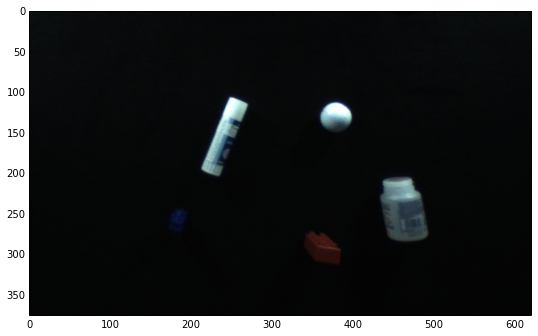

In [16]:
idx = 34

fig, ax = plt.subplots(1, 1, figsize=(9, 9))
img = cv2.imread(image_samples[idx])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax.imshow(img)

h, w, d = img.shape

## Select patch size

In [17]:
def xy_ranges(img_size, window_size, stride, zero_padding):
    r0 = -zero_padding[1] + window_size[1]
    r1 = img_size[1] + zero_padding[1] - window_size[1]
    y_range = np.arange(start=r0, stop=r1, step=stride[1])
    
    c0 = -zero_padding[0] + window_size[0]
    c1 = img_size[0] + zero_padding[0] - window_size[0]
    x_range = np.arange(start=c0, stop=c1, step=stride[0])
    
    print (
        "Image has {0}x{1} pixels. ".format(*img_size) + 
        "With a patch size of {0}x{1} pixels, ".format(*[2*i+1 for i in window_size]) +
        "a stride of ({0}, {1}) and ".format(*stride) +
        "a zero padding of ({0}, {1}) ".format(*zero_padding) +
        "we end up with %ix%i=%i patches." % (len(x_range), len(y_range), len(x_range)*len(y_range))
    )
    
    return x_range, y_range

In [18]:
window_size = (22, 22)
stride = (15, 15)
zero_padding = (0, 0)

x_range, y_range = xy_ranges((w, h), window_size, stride, zero_padding)

Image has 620x375 pixels. With a patch size of 45x45 pixels, a stride of (15, 15) and a zero padding of (0, 0) we end up with 39x23=897 patches.


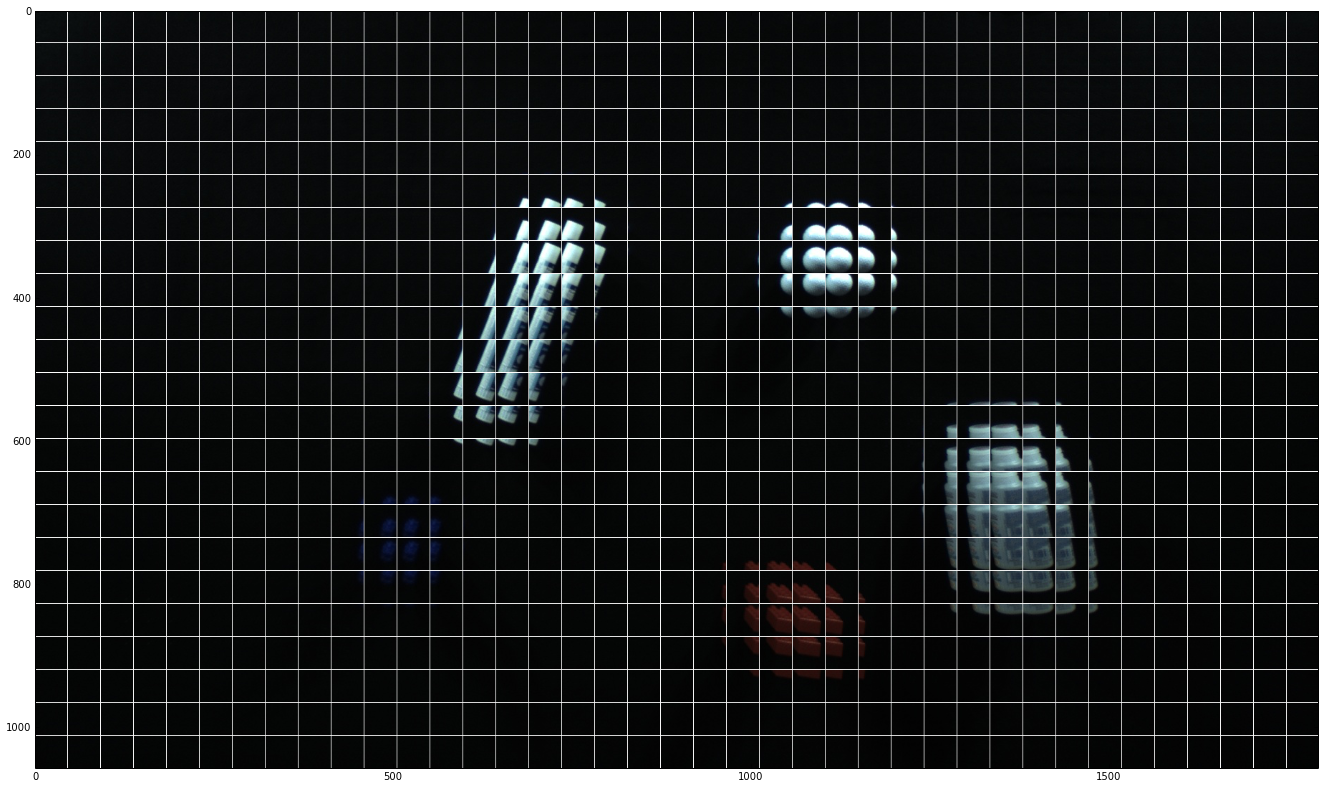

In [28]:
patch_shape = [2*i+1 for i in window_size] + [3, ]

# List patches in image
patches = np.empty((len(x_range)*len(y_range), np.prod(patch_shape)))
for xi, x in enumerate(x_range):
    for yi, y in enumerate(y_range):
        patch = img[y-window_size[1]:y+window_size[1]+1, x-window_size[0]:x+window_size[0]+1].view()
        patches[yi*len(x_range)+xi, :] = patch.reshape((1, -1))

# Plot patches as tile array
H, W = patch_shape[:2]
out_shape = [(ishp + tsp)*tshp - tsp for ishp, tshp, tsp 
             in zip((H, W), (len(y_range), len(x_range)), (1, 1))]
out_array = 255*np.ones(out_shape + [d,], dtype='uint8')

for tile_row in range(len(y_range)):
    for tile_col in range(len(x_range)):
        this_img = patches[tile_row*len(x_range)+tile_col].reshape(patch_shape)
        out_array[
            tile_row*(H+1):tile_row*(H+1)+H, 
            tile_col*(W+1):tile_col*(W+1)+W
        ] = this_img
        
fig, ax = plt.subplots(1, 1, figsize=(23, 19))
ax.imshow(out_array)

## Process data

In [69]:
def patches_from_images(samples, x_range, y_range, patch_shape):
    if not isinstance(samples, list):
        samples = [samples, ]
    patches = np.empty((len(x_range)*len(y_range)*len(samples),
                       np.prod(patch_shape)))
    H, W = [(a-1)/2 for a in patch_shape[:2]]
    
    f = FloatProgress(min=0, max=len(image_samples))
    f.description = "Processing samples"
    display(f)
    for idx, sample in enumerate(samples):
        img = cv2.imread(sample)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for yi, y in enumerate(y_range):
            for xi, x in enumerate(x_range):
                patch = img[y-H:y+H+1, x-W:x+W+1].view()
                pos = idx*len(x_range)*len(y_range)+yi*len(x_range)+xi
                patches[pos, :] = patch.reshape((1, -1))
                f.value = pos
    return patches

In [44]:
# Training, validation and test set split (in [%])
split = (70, 15, 15)

n_images = [int(np.floor(.01*p*len(image_samples))) 
            for p in split]
print n_images, np.sum(n_images)
n_patches = [n*len(x_range)*len(y_range) for n in n_images]
print n_patches

train_images = image_samples[:n_images[0]]
val_images = image_samples[n_images[0]:n_images[0]+n_images[1]]
test_images = image_samples[n_images[0]+n_images[1]:]

[70, 15, 15] 100
[62790, 13455, 13455]
[70, 15, 15]


### Training set

In [50]:
train_filename = os.path.join(out_dirname, 'train.txt')

start = time.time()
train_data = patches_from_images(train_images, 
                                 x_range, y_range, patch_shape)
np.savetxt(train_filename, train_data, delimiter=' ', fmt='%u')
print "Wrote %i samples in %.2fs to %s." % \
    (len(train_images), time.time()-start, train_filename)

(62790L, 6075L)
Wrote 70 samples in 290.26s to \\srv-file.brml.tum.de\nthome\mludersdorfer\reallyMyDocuments\code\baxter_pick_and_place\data\synthetic_demo_data\vae\train.txt.


### Validation set

In [51]:
val_filename = os.path.join(out_dirname, 'val.txt')

start = time.time()
val_data = patches_from_images(val_images, 
                               x_range, y_range, patch_shape)
np.savetxt(val_filename, val_data, delimiter=' ', fmt='%u')
print "Wrote %i samples in %.2fs to %s." % \
    (len(val_images), time.time()-start, val_filename)

Wrote 15 samples in 60.31s to \\srv-file.brml.tum.de\nthome\mludersdorfer\reallyMyDocuments\code\baxter_pick_and_place\data\synthetic_demo_data\vae\val.txt.


### Test set

In [70]:
start = time.time()
test_infoname = os.path.join(out_dirname, 'test.info')
if os.path.exists(test_infoname):
    os.remove(test_infoname)
for idx, test_image in enumerate(test_images):
    test_filename = os.path.join(out_dirname, 
                                 'test_%s.txt' % str(idx).zfill(2))
    test_data = patches_from_images(test_image, 
                                    x_range, y_range, patch_shape)
    np.savetxt(test_filename, test_data, delimiter=' ', fmt='%u')
    with open(test_infoname, 'a') as wfp:
        wfp.write('%s %s\n' % (test_image.split(package_dirname)[-1], 
                               test_filename.split(package_dirname)[-1]))
print "Wrote %i test images in %.2fs." % (len(test_images), 
                                          time.time()-start)

Wrote 15 test images in 61.37s.
